In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup as bs
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import requests
from geopy.geocoders import Nominatim
from datetime import date
import matplotlib.pyplot as plyt
import seaborn as sns
from geopy.geocoders import Nominatim
%matplotlib inline

In [101]:
login = pd.read_csv(r'C:\Users\paulf\OneDrive\Desktop\foursquare.csv')
v = date.today().strftime('%Y%m%d')

geolocator = Nominatim(user_agent = 'google')
geocodes = geolocator.geocode('Chicago, USA')
map_lat = geocodes.latitude
map_lng = geocodes.longitude

### Get Top 30 Venues in Chicago Aera

In [9]:
venue = requests.get('https://foursquare.com/explore?mode=url&near=New%20York%2C%20NY%2C%20United%20States&nearGeoId=72057594043056517&q=Top%20Picks')
soup = bs(venue.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <title>
   Top Picks New York, NY
  </title>
  <meta content="en" http-equiv="Content-Language"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="Foursquare" name="application-name"/>
  <meta content="#0ca9c9" name="msapplication-TileColor"/>
  <meta content="https://playfoursquare.s3.amazonaws.com/misc/foursquare-144-logo.png" name="msapplication-TileImage"/>
  <meta content="Start the foursquare App" name="msapplication-tooltip"/>
  <meta content="/" name="msapplication-starturl"/>
  <meta content="width=1024;height=768" name="msapplication-window"/>
  <meta content="name=Recent Check-ins; action-uri=/; icon-uri=/favicon.ico" name="msapplication-task"/>
  <meta content="name=Profile;action-uri=/user;icon-uri=/favicon.ico" name="msapplication-task"/>
  <meta content="name=His

In [10]:
venue_list = soup.find('div', id = 'results').find_all('li')
column_name = ['venue_name', 'venue_id', 'venue_score', 'venue_address', 'venue_lat', 'venue_lng']
venue_col = pd.DataFrame(columns = column_name)
venue_name = []
venue_id = []
venue_score=[]
venue_address =[]
venue_lat = []
venue_lng = []

for venue in venue_list:
    try:
        if venue.attrs.get('data-id') != None:
            venue_id.append(venue.attrs.get('data-id'))
            venue_name.append(venue.find('div', class_ = 'venueName').a.get_text())
            venue_score.append(venue.find('div', class_ = 'venueScore positive').get_text())
            venue_address.append(venue.find('div', class_ = 'venueAddress').get_text())
    except:
        continue

venue_col['venue_name'] = venue_name
venue_col['venue_id'] = venue_id
venue_col['venue_score'] = venue_score
venue_col['venue_address'] = venue_address

for index, row in venue_col.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row[1], 
                                                                                              login.iloc[0,0], login.iloc[0,1],v)
    result = requests.get(url).json()
    venue_lat.append(result['response']['venue']['location']['lat'])
    venue_lng.append(result['response']['venue']['location']['lng'])

venue_col['venue_lat'] = venue_lat
venue_col['venue_lng'] = venue_lng
venue_col.head()

,venue_name,venue_id,venue_score,venue_address,venue_lat,venue_lng
0,Central Park,412d2800f964a520df0c1fe3,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
1,Brooklyn Bridge Park,430d0a00f964a5203e271fe3,9.7,"Main St (Plymouth St), Brooklyn",40.702282,-73.996456
2,Los Tacos No. 1,59580ce6db1d8148fee3d383,9.6,"229 W 43rd St (btwn 7th & 8th Ave), New York",40.757134,-73.987536
3,Hudson River Greenway Running Path,4ed6adfce5fabbd89f617d4f,9.6,Hudson River Greenway (btwn Battery Park & W 7...,40.732552,-74.010580
4,Metropolitan Museum of Art,427c0500f964a52097211fe3,9.6,"1000 5th Ave (btwn E 80th & E 84th St), New York",40.779729,-73.963416


### Find Nearby Restaurants for Each Venue

In [11]:
restaurant_column = ['venue_id', 'food_name', 'food_cat', 'food_lat', 'food_lng']
categoryId = '4d4b7105d754a06374d81259'
radius = 500
limit = 30
restaurant_col = pd.DataFrame(columns = restaurant_column)

In [12]:
for index, row in venue_col.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            login.iloc[0,0], login.iloc[0,1], row[4], row[5], v, categoryId, radius, limit)
    result = requests.get(url).json()['response']
    for food in result['venues']:
        restaurant_col = restaurant_col.append({'venue_id': row[1], 'food_name': food['name'],
                                                'food_cat': food['categories'][0]['name'],
                                                'food_lat': food['location']['lat'],
                                                'food_lng': food['location']['lat']}, ignore_index = True)


restaurant_col = restaurant_col.merge(venue_col, how = 'inner', left_on = 'venue_id', right_on = 'venue_id')
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,40.780246,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
1,412d2800f964a520df0c1fe3,Herm's Box Food Truck,Food Truck,40.787367,40.787367,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
2,412d2800f964a520df0c1fe3,Starbucks,Coffee Shop,40.780136,40.780136,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
3,412d2800f964a520df0c1fe3,Café Sabarsky,Austrian Restaurant,40.781445,40.781445,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
4,412d2800f964a520df0c1fe3,Starbucks Reserve,Coffee Shop,40.779850,40.779850,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853


In [14]:
### restaurant_col.to_csv(r'C:\Users\paulf\OneDrive\Desktop\restaurant_col.csv') ###

In [2]:
### restaurant_col = pd.read_csv(r'C:\Users\paulf\OneDrive\Desktop\restaurant_col.csv', index_col = 0)
### restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,40.780246,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
1,412d2800f964a520df0c1fe3,Herm's Box Food Truck,Food Truck,40.787367,40.787367,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
2,412d2800f964a520df0c1fe3,Starbucks,Coffee Shop,40.780136,40.780136,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
3,412d2800f964a520df0c1fe3,Café Sabarsky,Austrian Restaurant,40.781445,40.781445,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853
4,412d2800f964a520df0c1fe3,Starbucks Reserve,Coffee Shop,40.779850,40.779850,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853


### Use KMeans and GridSearchCV to cluster venues based on restaurant type

In [3]:
restaurant_pivot = restaurant_col.pivot_table(values = ['food_name'], index = ['venue_name'], columns = ['food_cat'],
                           aggfunc = lambda x: len(x), fill_value = 0).apply(lambda x: x/x.sum(), axis = 1)
new_column = restaurant_pivot.columns.droplevel(0)
restaurant_pivot.columns = new_column
restaurant_pivot.index.name = None
restaurant_pivot.columns.name = None
restaurant_pivot.head()

,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bagel Shop,Bakery,Bar,Bistro,Bookstore,Bubble Tea Shop,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
Aire Ancient Baths,0.033333,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.100000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Astor Wines & Spirits,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.033333,0.033333,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0
Bethesda Fountain,0.068966,0.000000,0.0,0.0,0.0,0.068966,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Brooklyn Bridge,0.133333,0.000000,0.0,0.0,0.0,0.066667,0.033333,0.0,0.033333,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Brooklyn Bridge Park,0.133333,0.000000,0.0,0.0,0.0,0.066667,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
param_var = [{'n_clusters': np.arange(5,12), 'n_init': np.arange(5,16), 'max_iter': np.linspace(100, 500, 9)}]
search_cv = GridSearchCV(KMeans(random_state = 1), param_var).fit(restaurant_pivot)
best_params = search_cv.best_params_

D:\Work\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [5]:
kmeans = KMeans(n_clusters = best_params['n_clusters'], n_init = best_params['n_init'], max_iter = best_params['max_iter']).fit(restaurant_pivot)
kmeans.labels_[:5]

array([2, 2, 5, 0, 0])

In [6]:
restaurant_pivot['Label'] = kmeans.labels_.tolist()
restaurant_pivot.reset_index(inplace = True)
restaurant_pivot = restaurant_pivot.iloc[:,[0,-1]]
restaurant_pivot.rename(columns = {'index': 'venue_name'}, inplace = True)
restaurant_pivot.head()

,venue_name,Label
0,Aire Ancient Baths,2
1,Astor Wines & Spirits,2
2,Bethesda Fountain,5
3,Brooklyn Bridge,0
4,Brooklyn Bridge Park,0


In [7]:
restaurant_col = restaurant_col.merge(restaurant_pivot, on = 'venue_name')
restaurant_col_group = restaurant_col.groupby('food_cat').count()['food_name'].reset_index()
shuffle = np.arange(restaurant_col_group.shape[0])
np.random.shuffle(shuffle)
restaurant_col_group['color_index'] = shuffle
restaurant_col = restaurant_col.merge(restaurant_col_group[['food_cat', 'color_index']], on = 'food_cat')
restaurant_col_plot = pd.DataFrame(restaurant_col.groupby('venue_name')['venue_score'].mean()).reset_index()
restaurant_col_plot = restaurant_col_plot.merge(restaurant_pivot, on = 'venue_name').pivot_table(index = 'Label', columns = 'venue_name',
                                                                                                values = 'venue_score', fill_value = 0)

In [8]:
restaurant_col_group = restaurant_col.groupby('food_cat').count()['food_name'].reset_index()

In [9]:
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,40.780246,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
1,412d2800f964a520df0c1fe3,Cafe Fledermaus,Café,40.781256,40.781256,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
2,412d2800f964a520df0c1fe3,Bluestone Lane,Café,40.783757,40.783757,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
3,412d2800f964a520df0c1fe3,The Petrie Court Cafe & Wine Bar,Café,40.779160,40.779160,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
4,412d2800f964a520df0c1fe3,Cafe 3,Café,40.783157,40.783157,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12


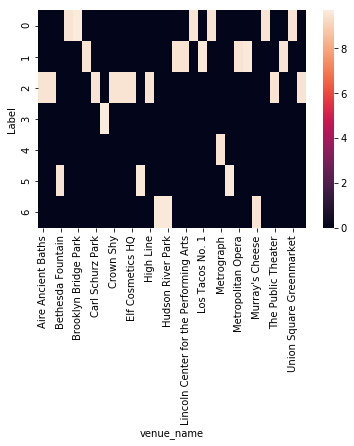

In [10]:
sns.heatmap(restaurant_col_plot)

In [107]:
from matplotlib import cm
from matplotlib import colors
import folium

In [156]:
n_rainbow_venue = restaurant_pivot.Label.max()
n_rainbow_venue = restaurant_col_group.shape[0]
color_array_venue = cm.rainbow(np.linspace(0, 1, n_rainbow))
color_venue = [colors.rgb2hex(i) for i in color_array]
color_array_food = cm.rainbow(np.linspace(0, 1, n_rainbow_venue))
color_food = [colors.rgb2hex(i) for i in color_array_food]

In [169]:
def add_marker(location, color_map, marker_size, food_map):
    for lat, lng, color_index, name in zip(location.iloc[:, 0], location.iloc[:, 1], location[:, 2], location[:, 3]):
        pop_up = folium.Popup(name, parse_html = True)
        folium.CircleMarker(loaction = [lat, lng], radius = marker_size, popup = pop_up,
                            color = color_map[color_index], fill = True, filll_color = color_map[color_index], 
                            fill_opacity = 0.7).add_to(food_map)


In [170]:
map_food = folium.Map(location = [map_lat, map_lng], zoon_start = 11)
food_input = restaurant_col[['food_lat', 'food_lng', 'color_index', 'food_cat']]
venue_input = restaurant_col[['venue_lat', 'venue_lng', 'Label', 'venue_name']].drop_duplicates()

add_marker(food_input, color_food, 2, map_food)
add_marker(venue_input, color_venue, 4, map_food)
map_food

KeyError: "['color_index'] not in index"

In [12]:
restaurant_col[['venue_lat', 'venue_lng', 'Label', 'venue_name']].drop_duplicates()

,venue_lat,venue_lng,Label,venue_name
0,40.784083,-73.964853,3,Central Park
5,40.702282,-73.996456,0,Brooklyn Bridge Park
6,40.757134,-73.987536,1,Los Tacos No. 1
8,40.779729,-73.963416,5,Metropolitan Museum of Art
12,40.746558,-73.958051,5,Gantry Plaza State Park
16,40.757389,-73.985537,1,Minskoff Theatre
18,40.753621,-73.983265,1,Bryant Park
21,40.729169,-73.992070,2,The Public Theater
22,40.727984,-73.993047,2,Astor Wines & Spirits
23,40.746825,-74.005507,2,High Line


In [13]:
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,40.780246,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
1,412d2800f964a520df0c1fe3,Cafe Fledermaus,Café,40.781256,40.781256,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
2,412d2800f964a520df0c1fe3,Bluestone Lane,Café,40.783757,40.783757,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
3,412d2800f964a520df0c1fe3,The Petrie Court Cafe & Wine Bar,Café,40.779160,40.779160,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
4,412d2800f964a520df0c1fe3,Cafe 3,Café,40.783157,40.783157,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12


D:\Work\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


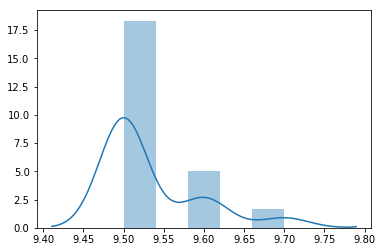

In [21]:
test = restaurant_col.groupby('venue_name')[['venue_score']].mean()
sns.distplot(test)

In [24]:
test.reset_index(inplace = True)

In [25]:
test.head()

,venue_name,venue_score
0,Aire Ancient Baths,9.5
1,Astor Wines & Spirits,9.5
2,Bethesda Fountain,9.5
3,Brooklyn Bridge,9.5
4,Brooklyn Bridge Park,9.7


In [27]:
restaurant_col.head()

,venue_id,food_name,food_cat,food_lat,food_lng,venue_name,venue_score,venue_address,venue_lat,venue_lng,Label,color_index
0,412d2800f964a520df0c1fe3,American Wing Cafe,Café,40.780246,40.780246,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
1,412d2800f964a520df0c1fe3,Cafe Fledermaus,Café,40.781256,40.781256,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
2,412d2800f964a520df0c1fe3,Bluestone Lane,Café,40.783757,40.783757,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
3,412d2800f964a520df0c1fe3,The Petrie Court Cafe & Wine Bar,Café,40.779160,40.779160,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12
4,412d2800f964a520df0c1fe3,Cafe 3,Café,40.783157,40.783157,Central Park,9.7,59th St to 110th St (5th Ave to Central Park W...,40.784083,-73.964853,3,12


D:\Work\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


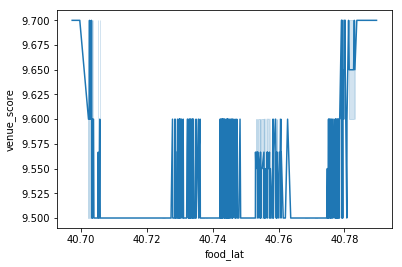

In [33]:
sns.lineplot(x = 'food_lat', y = 'venue_score', data = restaurant_col)